### Ultimate Data Science Challenge

Data:
- logins.json
- ultimate_data_challenge.json

### Part 1 ‑ Exploratory data analysis

A. logins Dataset

1.1. Load data, convert to datetime, and resample to 15 min intervals

In [1]:
import pandas as pd

df1=pd.read_json('logins.json')
#change to datetime
df1=pd.to_datetime(df1['login_time'])
df1=pd.DataFrame(df1) #change to a DataFrame 

df1['Counts']=1 #crete a new column
df1.head() #check


,login_time,Counts
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [2]:
#resample data in 15 min increments
#https://stackoverflow.com/questions/14861023/resampling-minute-data

df1=df1.set_index('login_time') 
df1=df1.resample('15Min').sum()
df1.head() #check

,Counts
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [3]:
df1.isnull().sum() #count number of null entries.

Counts    407
dtype: int64

In [4]:
#set null entries to zero
df1=df1.fillna(0) #fill na entries with 0
df1.isnull().sum() #check

Counts    0
dtype: int64

1.2. Visualize data

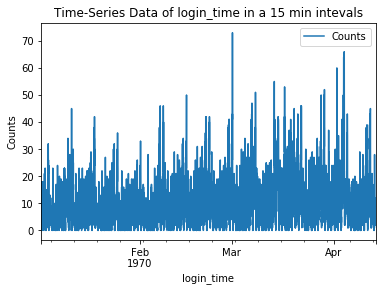

In [5]:
import matplotlib.pyplot as plt

df1.plot()
plt.ylabel('Counts')
plt.title('Time-Series Data of login_time in a 15 min intevals')
plt.show()

In [6]:
#resample into daily intervals
df1=df1.resample('D').sum()
df1.isnull().sum() #check

Counts    0
dtype: int64

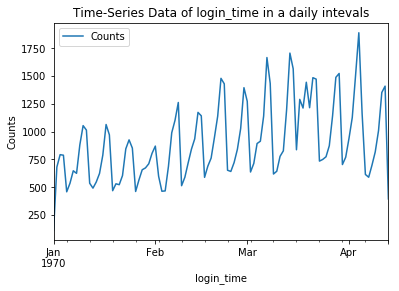

In [7]:
df1.plot()
plt.ylabel('Counts')
plt.title('Time-Series Data of login_time in a daily intevals')
plt.show()

- The above time-series data shows the number of logins over per 15 min interval and per day
- Overall, the time series data looks cyclical    
- There is an obvious anomaly in the cyclical pattern during the 3rd week of March  
- The amplitude is generally lower in the beginning, and it increases with time

1.3. Characterize Data

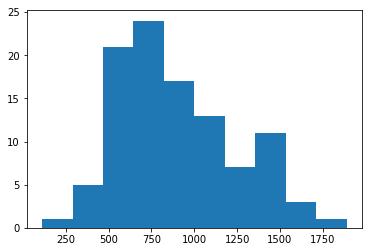

In [44]:
#df1.Counts.plot(kind='hist')

plt.hist(df1.Counts)
plt.show()


Time-series decomposition

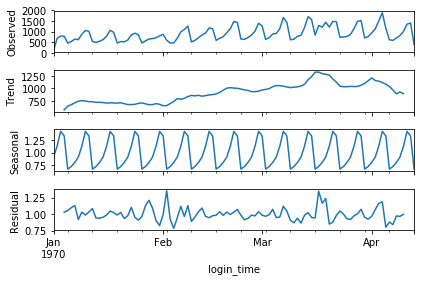

In [38]:
#decompose time-series data
#ref.: Jason Brownlee, "Introduction to Time Series Forecasting with Python", Machine Learning Mastery, pg.123
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(df1.Counts,model='multiplicative')
result.plot()
plt.show()

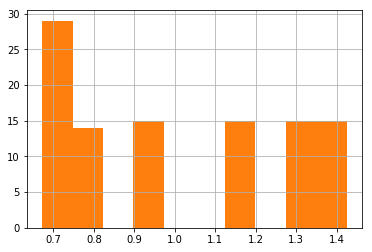

In [41]:
result.seasonal.hist()
plt.show()

- The seasonal component clearly shows a cyclical trend in the data 

1.3. Characterize Counts

In [8]:
#add a new column, day
#insert dayofweek column
#https://stackoverflow.com/questions/18674064/how-do-i-insert-a-column-at-a-specific-column-index-in-pandas
df1.insert(0, 'Dayofweek', df1.index.dayofweek)

df1.head() #check

,Dayofweek,Counts
login_time,,
1970-01-01,3,112.0
1970-01-02,4,681.0
1970-01-03,5,793.0
1970-01-04,6,788.0
1970-01-05,0,459.0


In [9]:
#determine on what days of the week are the counts minimum
#filter using weekly mean

#get weekly average
df_weekly_avg=pd.DataFrame(df1['Counts'].resample('W').mean())
#rename column
df_weekly_avg.columns=['Weekly_avg']
df_weekly_avg.head()#check

,Weekly_avg
login_time,
1970-01-04,593.500000
1970-01-11,745.285714
1970-01-18,717.571429
1970-01-25,678.714286
1970-02-01,677.714286


In [10]:
#concat by index
df_combined=pd.concat([df1,df_weekly_avg],axis=1)
df_combined.head() #check

,Dayofweek,Counts,Weekly_avg
login_time,,,
1970-01-01,3.0,112.0,NaN
1970-01-02,4.0,681.0,NaN
1970-01-03,5.0,793.0,NaN
1970-01-04,6.0,788.0,593.5
1970-01-05,0.0,459.0,NaN


In [11]:
#fill blanks with backward fill 
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html

df_combined=df_combined.fillna(method='bfill')
df_combined.head() #check

,Dayofweek,Counts,Weekly_avg
login_time,,,
1970-01-01,3.0,112.0,593.500000
1970-01-02,4.0,681.0,593.500000
1970-01-03,5.0,793.0,593.500000
1970-01-04,6.0,788.0,593.500000
1970-01-05,0.0,459.0,745.285714


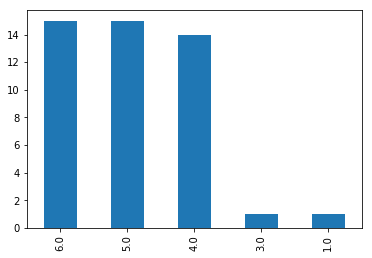

In [12]:
#https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.Series.dt.dayofweek.html
#Monday=0, Sunday=6

#filter for the DayofWeek for data that are above the weekly average
df_combined[df_combined['Counts']>df_combined['Weekly_avg']]['Dayofweek'].value_counts().plot(kind='bar')
plt.show()

- It is seen that the counts are above average on Thursday (4), Friday (5), and Saturday (6).

### Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### 2.1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

If the experiment is successful, more cars will pass through the toll road. Therefore, a key measure of success is the percent increase in the number of cars passing through the toll road after the toll costs reimbursement program is introduced.

##### 2.2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
#### a. how you will implement the experiment  
A practical way to implement the experiment is to give drivers a membership card which can be used to admit the driver into the toll road free of charge. Each time the driver enter the toll road, the card is scanned and the entry is recorded. This is a more efficient approach than having the driver to reimburst payments.

#### b. what statistical test(s) you will conduct to verify the significance of the observation  
I will perform a paired/dependent t-test. I will compare the number of cars passing through the toll roads before and after the toll costs reimbursement program is introduced.

#### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.  
I will choose an alpha value of 5%. The null hypothesis would state that the mean difference in the average number of cars passing through the toll roads before and after the program is introduced is zero. The alternative hypothesis would state that the mean difference is greater than zero.


### Part 3 ‑ Predictive modeling

#### 3.1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

A. Import and inspect data

In [13]:
#https://stackoverflow.com/questions/36837663/reading-json-file-as-pandas-dataframe-error
import pandas as pd
import json

#import as json
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

#convert into pandas
df2=pd.DataFrame(data)
df2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [14]:
#inspect data
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


- There are missing data for: 
    - avg_rating_by_driver
    - avg_rating_of_driver
    - phone

In [15]:
#check the number of cities

set(df2.city) 

{'Astapor', "King's Landing", 'Winterfell'}

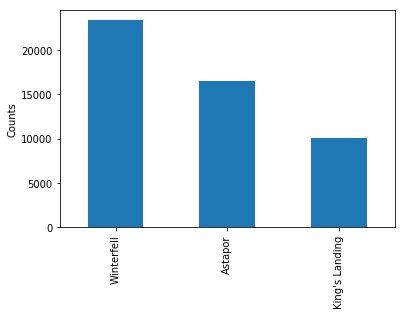

In [16]:
#do counts of number of entries per city

df2.city.value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

- There are three cities

B. Add an additional column to indicate if the user is active or not

In [17]:

df2['Active_or_not']=df2.trips_in_first_30_days>0
df2.head() #check


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,Active_or_not
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,True
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,True


In [18]:
#fraction of observed users that were retained:

#check if there are nulls
df2.Active_or_not.isnull().sum()
#there are no null values

0

- Since there are no missing values, data treatment is not needed.

In [19]:
#fraction of observed users that were retained:

fract_ret=df2[df2.Active_or_not==True]['Active_or_not'].value_counts().sum()/df2.Active_or_not.value_counts().sum()
print('The fraction of observed users that were retained is: %s' %(fract_ret))

The fraction of observed users that were retained is: 0.6922


#### 3.2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [20]:
#create a new column to show the length of time the user has been a user.
#calculate the time-delta between signup_date and last_trip_date
#https://stackoverflow.com/questions/22923775/calculate-pandas-dataframe-time-difference-between-two-columns-in-hours-and-minu

df2['length_of_service']=(pd.to_datetime(df2.last_trip_date) - pd.to_datetime(df2.signup_date))
df2.head() #check

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,Active_or_not,length_of_service
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True,143 days
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False,96 days
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,True,1 days
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True,170 days
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,True,47 days


In [21]:
#add a new column to indicate if user has signed up for at least 5 months.
df2['at_least_5_months']=df2.length_of_service.dt.days > 150
df2[df2['at_least_5_months']==True] #check
df2.head() #check

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,Active_or_not,length_of_service,at_least_5_months
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True,143 days,False
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False,96 days,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,True,1 days,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True,170 days,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,True,47 days,False


In [22]:
#only keep users that have signed up for at least 5 months

df_signed_up_at_least_5_mths=df2[df2.at_least_5_months==True]
df_signed_up_at_least_5_mths #check

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,Active_or_not,length_of_service,at_least_5_months
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True,170 days,True
16,10.86,3.0,5.0,1.00,King's Landing,2014-06-28,Android,2014-01-11,0.0,1,True,50.0,True,168 days,True
17,2.38,4.8,3.9,1.00,King's Landing,2014-07-01,iPhone,2014-01-12,0.0,0,True,95.2,False,170 days,True
19,12.08,5.0,5.0,1.17,King's Landing,2014-06-03,iPhone,2014-01-02,33.3,0,False,66.7,False,152 days,True
32,10.01,5.0,4.0,2.00,Winterfell,2014-06-10,iPhone,2014-01-05,100.0,1,False,100.0,True,156 days,True
36,2.43,4.5,NaN,1.00,Astapor,2014-06-25,iPhone,2014-01-21,0.0,2,False,50.0,True,155 days,True
38,4.69,4.8,4.9,1.04,King's Landing,2014-06-30,iPhone,2014-01-22,5.8,24,True,61.6,True,159 days,True
39,13.73,5.0,NaN,1.00,King's Landing,2014-06-23,iPhone,2014-01-09,0.0,1,True,100.0,True,165 days,True
49,10.54,4.7,4.4,1.00,Winterfell,2014-06-19,iPhone,2014-01-04,0.0,2,False,71.4,True,166 days,True
54,4.94,5.0,3.5,1.50,Winterfell,2014-06-15,iPhone,2014-01-10,50.0,2,False,50.0,True,156 days,True


In [23]:
#count number of users wo got into the sixth month
df_signed_up_at_least_5_mths.shape[0]

12198

In [24]:
#number of users initially

df2.shape[0]

50000

In [25]:
#fraction of users who have signed up for at least 5 months
12198/50000

0.24396

- Only 24.4% users have signed up for at least 5 months. 

***

In [26]:
#select just the data in which the users have signed up for at least 5 months.
#do modeling and see which ones remain active.

In [27]:
#create a new dataframe with relevant fields.
#change data type as needed 
#plot out the data to visualize

df_signed_up_at_least_5_mths_selected=pd.DataFrame(df2.loc[:,['avg_dist', \
                                                'avg_rating_by_driver', \
                                                'avg_rating_of_driver', \
                                                'avg_surge', \
                                                'surge_pct', \
                                                'trips_in_first_30_days', \
                                                'ultimate_black_user', \
                                                'weekday_pct']])
df_signed_up_at_least_5_mths_selected.head() #check

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4


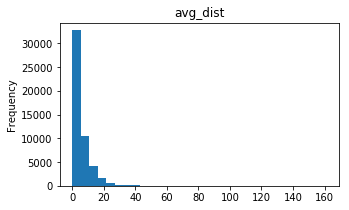

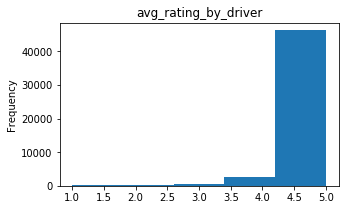

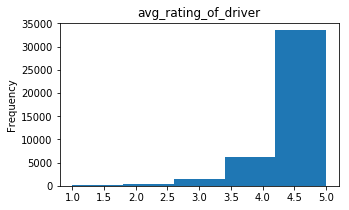

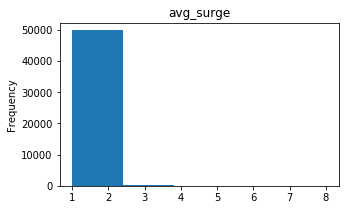

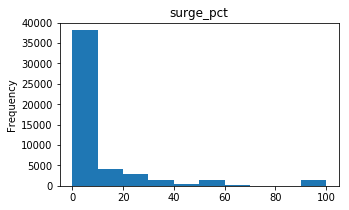

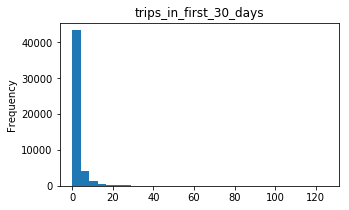

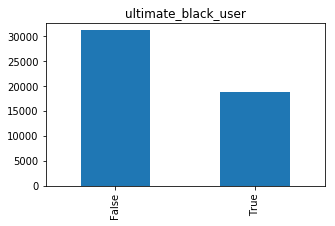

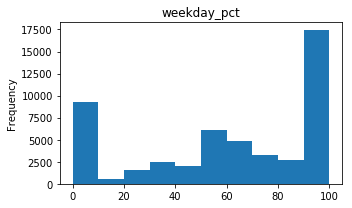

In [28]:
plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_dist'].plot(kind='hist', bins=30)
plt.title('avg_dist')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_rating_by_driver'].plot(kind='hist', bins=5)
plt.title('avg_rating_by_driver')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_rating_of_driver'].plot(kind='hist', bins=5)
plt.title('avg_rating_of_driver')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_surge'].plot(kind='hist', bins=5)
plt.title('avg_surge')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['surge_pct'].plot(kind='hist', bins=10)
plt.title('surge_pct')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['trips_in_first_30_days'].plot(kind='hist', bins=30)
plt.title('trips_in_first_30_days')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['ultimate_black_user'].value_counts().plot(kind='bar')
plt.title('ultimate_black_user')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['weekday_pct'].plot(kind='hist', bins=10)
plt.title('weekday_pct')
 
            
plt.tight_layout()
plt.show()


- The above charts show that the following fields show skewed distributions:
        - avg_dist
        - avg_rating_by_driver
        - avg_rating_of_driver
        - avg_surge
        - surge_pct
        - trips_in_first_30_days
        

#### 3.3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

#### Data description

● city: city this user signed up in  
● phone: primary device for this user  
● signup_date: date of account registration; in the form ‘YYYY MM DD’  
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’  
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup  
● avg_rating_by_driver: the rider’s average rating over all of their trips  
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips  
● surge_pct: the percent of trips taken with surge multiplier > 1  
● avg_surge: The average surge multiplier over all of this user’s trips  
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up  
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise  
● weekday_pct: the percent of the user’s trips occurring during a weekday  